In [1]:
import os 
import glob
import numpy as np
from sklearn.preprocessing import LabelEncoder 
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback
import cv2

In [2]:
# understanding the dataset structure
data_dir = '../images/'
training_path = data_dir+'train/'
validation_path = data_dir+'validation/'


# Training classes
print("--------- Training set description --------------")
print("S.No.\tSample Count\tClass\t")
# Printing distribution of each class in training set
for (i,expression) in enumerate(os.listdir(training_path)):
    print(str(i+1)+ "\t"+ str(len(os.listdir(training_path + expression))) + "\t\t" + expression )
    

# Validation classes
print("\n--------- Validation set description --------------")
print("S.No.\tSample Count\tClass\t")
# Printing distribution of each class in training set
for (i,expression) in enumerate(os.listdir(validation_path)):
    print(str(i+1)+ "\t"+ str(len(os.listdir(validation_path + expression))) + "\t\t" + expression )


--------- Training set description --------------
S.No.	Sample Count	Class	
1	7164		happy
2	4938		sad
3	4103		fear
4	3205		surprise
5	4982		neutral
6	3993		angry
7	436		disgust

--------- Validation set description --------------
S.No.	Sample Count	Class	
1	1825		happy
2	1139		sad
3	1018		fear
4	797		surprise
5	1216		neutral
6	960		angry
7	111		disgust


In [3]:
def create_dataset(main_path):
    label_encoder = LabelEncoder()

    df = {"img":[],"img_class":[]}
    for class_names in os.listdir(main_path):
        for img_path in glob.glob(f"{main_path}/{class_names}/*"):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))
            img = img[..., np.newaxis] / 255.0         
            df["img"].append(img)
            df["img_class"].append(class_names)
    df["img"] = np.array(df["img"], dtype='float32')
    df["img_class"] = label_encoder.fit_transform(df["img_class"])
    df["img_class"] = tf.keras.utils.to_categorical(df["img_class"])
    return df["img"],df["img_class"]
    
training_dataset, training_labels = create_dataset(training_path[:len(training_path)-1])
validation_dataset, validation_labels  = create_dataset(validation_path[:len(validation_path)-1])



In [4]:
# Defining constants 
BATCH_SIZE = 64
img_channel = 3
LEARNING_RATE = 0.0001

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='reflect'
)


<h3>Building Model</h3>

In [6]:

from tensorflow.keras.layers import Dense,  Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam


model = Sequential()

# 1 - Convolution
model.add(Conv2D(32, (3, 3),  input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))


# 2nd Convolution layer
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))


# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 64)       2

2023-03-26 00:21:58.488592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3,mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)

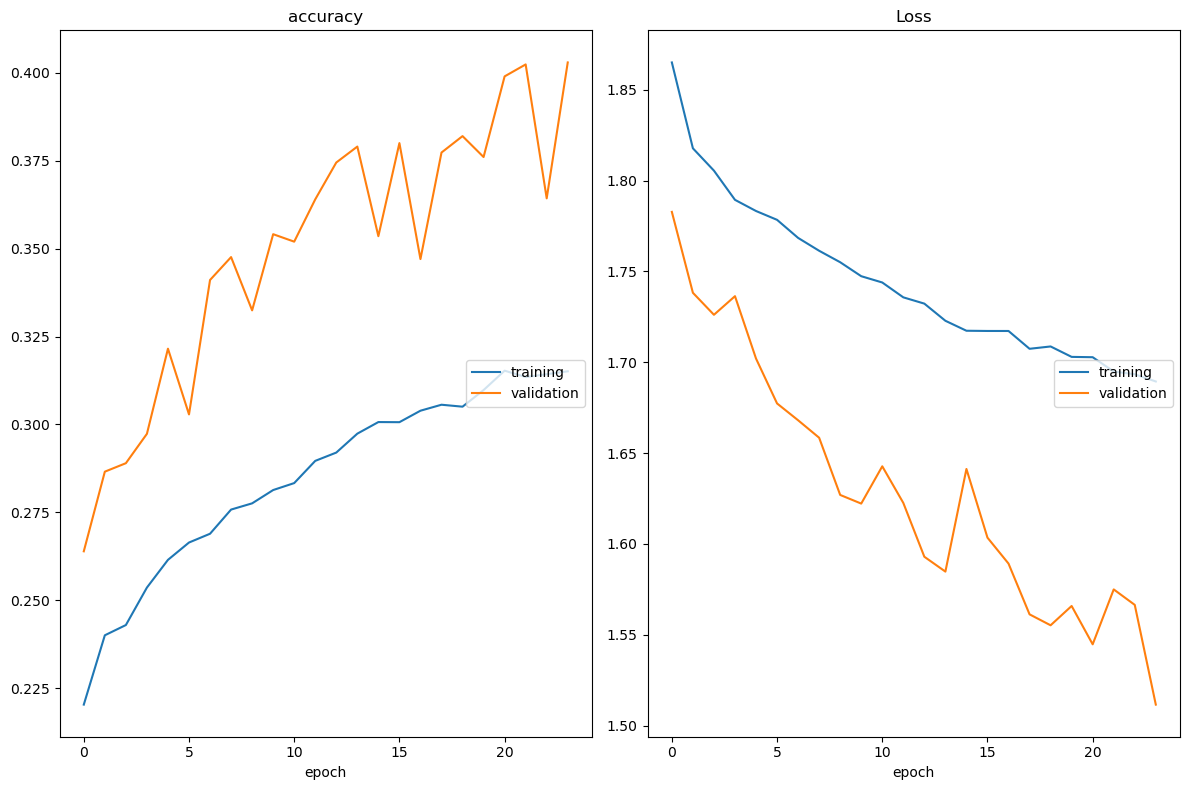

accuracy
	training         	 (min:    0.220, max:    0.315, cur:    0.315)
	validation       	 (min:    0.264, max:    0.403, cur:    0.403)
Loss
	training         	 (min:    1.689, max:    1.865, cur:    1.689)
	validation       	 (min:    1.512, max:    1.783, cur:    1.512)

Epoch 24: val_loss improved from 1.54474 to 1.51155, saving model to best_weights.h5
451/451 [==============================] - 35s 78ms/step - loss: 1.6894 - accuracy: 0.3151 - val_loss: 1.5116 - val_accuracy: 0.4029


In [8]:
history = model.fit(
    data_augmentation.flow(training_dataset, training_labels, batch_size=BATCH_SIZE),    
    epochs=100,
    callbacks=[PlotLossesCallback(),checkpoint, early_stopping],
    validation_data=(validation_dataset,validation_labels))


In [9]:
# Save Model
model.save("FacialExpressionModel.h5")